In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, SimpleRNN
from tensorflow.keras.layers import Flatten
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from sklearn.metrics import mean_absolute_error as mae
from pandas.tseries.offsets import BDay

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 14494480343520806349
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11320098816
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 1229225032833911937
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
 xla_global_id: 416903419]

In [3]:
df_main = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Stock Market/TESLA.csv')
df_main.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-08-16,45.098000,45.438000,44.681999,44.722000,44.722000,11335500
1,2016-08-17,44.866001,44.966000,44.560001,44.647999,44.647999,8935500
2,2016-08-18,44.764000,45.132000,44.458000,44.702000,44.702000,8572500
3,2016-08-19,44.708000,45.034000,44.506001,45.000000,45.000000,8297500
4,2016-08-22,44.834000,45.021999,44.535999,44.585999,44.585999,10327500


In [4]:
df_main.shape

(1258, 7)

In [ ]:
df_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1258 non-null   object 
 1   Open       1258 non-null   float64
 2   High       1258 non-null   float64
 3   Low        1258 non-null   float64
 4   Close      1258 non-null   float64
 5   Adj Close  1258 non-null   float64
 6   Volume     1258 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 68.9+ KB


In [5]:
time = pd.date_range(start='16/08/2016',periods=1258,freq=BDay())
df_main['time_stamp'] = pd.DataFrame(time)
df_main.drop(['Date'],axis=1,inplace=True)
df_main = df_main.set_index('time_stamp')

In [6]:
df = df_main[['Close']]

In [ ]:
df.head()

,Close
time_stamp,
2016-08-16,44.722000
2016-08-17,44.647999
2016-08-18,44.702000
2016-08-19,45.000000
2016-08-22,44.585999


In [ ]:
df.tail()

,Close
time_stamp,
2021-06-04,713.760010
2021-06-07,709.989990
2021-06-08,707.820007
2021-06-09,722.250000
2021-06-10,717.169983


In [7]:
plt.rcParams['figure.figsize'] = [15,8]

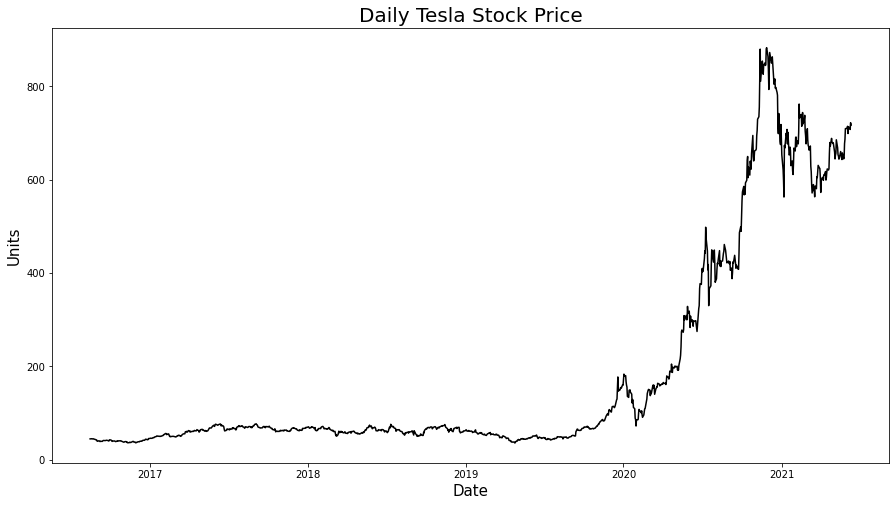

In [8]:
plt.plot(df,color='black')
plt.title('Daily Tesla Stock Price',fontsize=20)
plt.xlabel('Date',fontsize=15)
plt.ylabel('Units',fontsize=15)
plt.show()

In [9]:
def convert2matrix(data_arr, look_back):
    X, Y =[], []
    for i in range(len(data_arr)-look_back):
        d=i+look_back  
        X.append(data_arr[i:d,0])
        Y.append(data_arr[d,0])
    return np.array(X), np.array(Y)

In [28]:
from sklearn.preprocessing import MinMaxScaler
#create numpy.ndarray 
df['Close'] = df['Close'].astype(np.float32)
df_arr = df.values
df_arr = np.reshape(df_arr, (-1, 1))
scaler = MinMaxScaler(feature_range=(0.1, 1))
df_arr = scaler.fit_transform(df_arr)

In [29]:
#Split data set into testing dataset and train dataset
train_size = 1132
train, test =df_arr[0:train_size,:], df_arr[train_size:len(df_arr),:]
# setup look_back window 
look_back = 4
#convert dataset into right shape in order to input into the DNN
trainX, trainY = convert2matrix(train, look_back)
testX, testY = convert2matrix(test, look_back)
# reshape input to be [samples, window size, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [ ]:
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(1128, 1, 4)
(1128,)
(122, 1, 4)
(122,)


In [ ]:
!pip install -q -U keras-tuner

     |████████████████████████████████| 98 kB 3.5 MB/s 


In [ ]:
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from keras_tuner.tuners import RandomSearch
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.layers import Flatten
import matplotlib.pyplot as plt

In [ ]:
def build_model(hp):
    model = keras.Sequential()
    model.add(SimpleRNN(hp.Int('rnn_layer_1',min_value=16,max_value=256,step=8), activation="relu", input_shape=(1,look_back),recurrent_dropout = hp.Choice("recurrent_dropout",[0.2,0.3,0.4],default=0.2)))
    model.add(Dense(hp.Int('dense_layer_1',min_value=16,max_value=256,step=8),activation="relu"))
    model.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.1)))
    model.add(layers.Dense(1, activation='linear'))
    model.compile(
        optimizer=keras.optimizers.Adam(
             hp.Float('learning_rate', min_value=1e-3, max_value=1e-1, sampling="log")),
        loss='mape',
        metrics=['mape'])
    return model

In [ ]:
tuner = RandomSearch(
    build_model,
    objective='val_mape',
    max_trials=20,
    executions_per_trial=1,
    directory='project',
    project_name='loa_em_3')

In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 5
rnn_layer_1 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 256, 'step': 8, 'sampling': None}
recurrent_dropout (Choice)
{'default': 0.2, 'conditions': [], 'values': [0.2, 0.3, 0.4], 'ordered': True}
dense_layer_1 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 256, 'step': 8, 'sampling': None}
Dropout_rate (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': None}
learning_rate (Float)
{'default': 0.001, 'conditions': [], 'min_value': 0.001, 'max_value': 0.1, 'step': None, 'sampling': 'log'}


In [ ]:
tuner.search(trainX, trainY,
             epochs=200,
             batch_size=34,
             validation_data=(testX, testY))

Trial 20 Complete [00h 00m 40s]
val_mape: 80.70706176757812

Best val_mape So Far: 2.274986982345581
Total elapsed time: 00h 13m 32s
INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner.results_summary()

Results summary
Results in project/loa_em_3
Showing 10 best trials
Objective(name='val_mape', direction='min')
Trial summary
Hyperparameters:
rnn_layer_1: 104
recurrent_dropout: 0.2
dense_layer_1: 192
Dropout_rate: 0.2
learning_rate: 0.0011731575509484927
Score: 2.274986982345581
Trial summary
Hyperparameters:
rnn_layer_1: 24
recurrent_dropout: 0.3
dense_layer_1: 144
Dropout_rate: 0.4
learning_rate: 0.008790667623039506
Score: 2.278541326522827
Trial summary
Hyperparameters:
rnn_layer_1: 208
recurrent_dropout: 0.2
dense_layer_1: 208
Dropout_rate: 0.5
learning_rate: 0.0011455967056952644
Score: 2.2897934913635254
Trial summary
Hyperparameters:
rnn_layer_1: 224
recurrent_dropout: 0.4
dense_layer_1: 176
Dropout_rate: 0.30000000000000004
learning_rate: 0.017535200314706383
Score: 2.295276403427124
Trial summary
Hyperparameters:
rnn_layer_1: 224
recurrent_dropout: 0.4
dense_layer_1: 48
Dropout_rate: 0.1
learning_rate: 0.0010497756904456143
Score: 2.2988767623901367
Trial summary
Hyperparame

In [ ]:
from warnings import filterwarnings
filterwarnings('ignore')

In [ ]:
models = tuner.get_best_models(num_models=2)
best_model = models[0]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_model.build(input_shape=(None, 4))
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 104)               11336     
                                                                 
 dense (Dense)               (None, 192)               20160     
                                                                 
 dropout (Dropout)           (None, 192)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 193       
                                                                 
Total params: 31,689
Trainable params: 31,689
Non-trainable params: 0
_________________________________________________________________


In [12]:
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Bidirectional

In [30]:
model = Sequential()
model.add(Bidirectional(SimpleRNN(512,activation='relu',input_dim = 4,return_sequences=True)))
model.add(Bidirectional(SimpleRNN(256,activation='relu')))
model.add(Dense(1,activation='linear'))
ad=optimizers.Adam(learning_rate = 0.000011731575509484927)
model.compile(optimizer = ad, loss = 'mape', metrics = ['mape'])
model_history=model.fit(trainX, trainY,validation_data=(testX,testY), batch_size = 34, epochs = 300)

Epoch 1/300
34/34 [==============================] - 4s 30ms/step - loss: 87.9607 - mape: 87.9607 - val_loss: 73.0152 - val_mape: 73.0152
Epoch 2/300
34/34 [==============================] - 1s 16ms/step - loss: 47.3467 - mape: 47.3467 - val_loss: 39.6736 - val_mape: 39.6736
Epoch 3/300
34/34 [==============================] - 1s 15ms/step - loss: 12.3778 - mape: 12.3778 - val_loss: 16.0794 - val_mape: 16.0794
Epoch 4/300
34/34 [==============================] - 1s 15ms/step - loss: 5.6111 - mape: 5.6111 - val_loss: 16.4124 - val_mape: 16.4124
Epoch 5/300
34/34 [==============================] - 1s 15ms/step - loss: 5.0190 - mape: 5.0190 - val_loss: 14.9685 - val_mape: 14.9685
Epoch 6/300
34/34 [==============================] - 1s 16ms/step - loss: 4.6364 - mape: 4.6364 - val_loss: 12.9201 - val_mape: 12.9201
Epoch 7/300
34/34 [==============================] - 1s 15ms/step - loss: 4.2563 - mape: 4.2563 - val_loss: 11.6869 - val_mape: 11.6869
Epoch 8/300
34/34 [=======================

In [14]:
def model_loss(history):
    plt.figure(figsize=(8,4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Test Loss')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend(loc='upper right')
    plt.show();

In [31]:
train_score = model.evaluate(trainX, trainY,verbose=0)
test_score = model.evaluate(testX, testY,verbose=0)

Train MAPE : 1.61 
Test MAPE : 2.32 


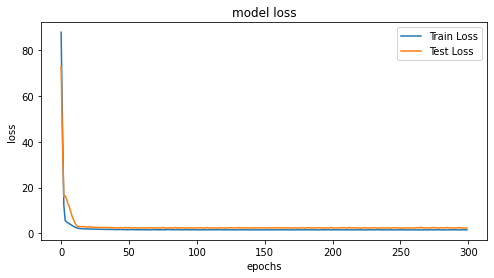

In [32]:
train_predict = model.predict(trainX)
test_predict = model.predict(testX)

# invert predictions
train_predict = scaler.inverse_transform(train_predict)
trainY = scaler.inverse_transform([trainY])
test_predict = scaler.inverse_transform(test_predict)
testY = scaler.inverse_transform([testY])
print('Train MAPE : %.2f ' % (train_score[1]))
print('Test MAPE : %.2f ' % (test_score[1]))
model_loss(model_history)

In [17]:
import seaborn as sns

In [18]:
def prediction_plot(testY, test_predict,look_back):
    len_prediction=[x for x in range(1128,1250)]
    plt.plot(trainY.reshape(-1,))
    plt.plot(len_prediction, testY.reshape(-1,), marker='.', label='actual')
    plt.plot(len_prediction, test_predict, 'g', label="prediction")
    plt.tight_layout()
    sns.despine(top=True)
    plt.subplots_adjust(left=0.07)
    plt.ylabel('Units', size=15)
    plt.xlabel('Time step', size=15)
    plt.legend(fontsize=15)
    plt.show()

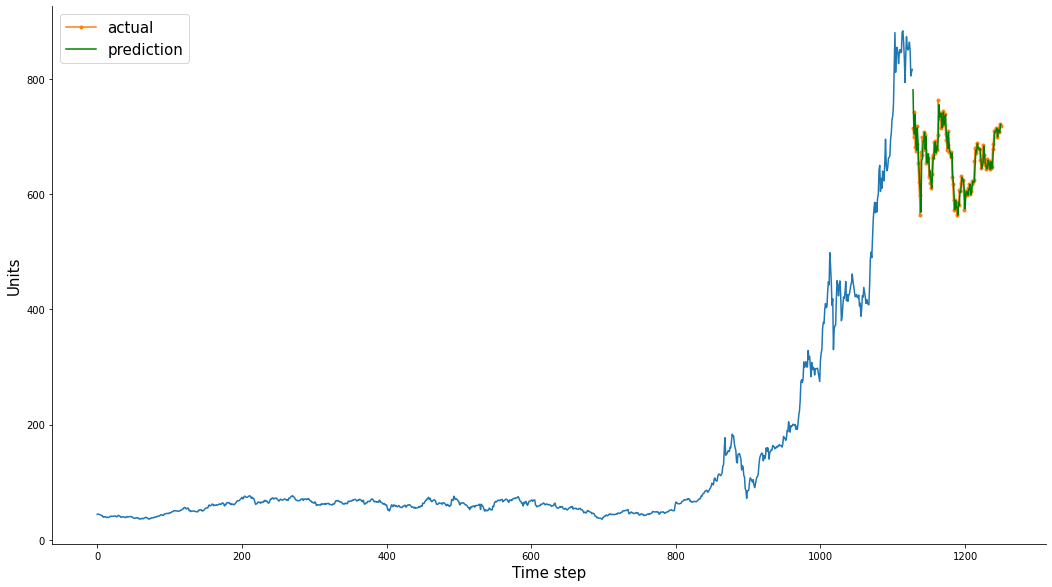

In [33]:
test_predict = model.predict(testX)
test_predict = scaler.inverse_transform(test_predict)
prediction_plot(testY, test_predict,look_back)